In [192]:
#Implementation of trb in rocketpy with notes about data: from where it was taken, if it is reliable and if not from where we want to take it in the future.

In [193]:
#Imports
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank
from math import exp
from datetime import datetime, timedelta
from rocketpy.simulation import FlightDataExporter

In [194]:
#Env
#Standard atmosphere - no wind for stable outcomes
env = Environment() # Using Standard Atmosphere by default

#Toruń Kod od Antka
# env = Environment(latitude=52.94401645806493, longitude=18.63890735729045)
# # 52.94401645806493, 18.63890735729045 toruń poligon <----
# moment = datetime.date.fromisoformat('2025-07-27')
# env.set_date((moment.year, moment.month, moment.day, 14))  # godizna w UTC (tam byla 15:51 GMT+2)
# env.set_atmospheric_model(type="Windy", file="GFS")
# env.max_expected_height = 10000


#Far-out
# tomorrow = datetime.now() + timedelta(days=1)
# env = Environment(
#     date=tomorrow,  
#     latitude=35.35,
#     longitude=-117.81, # Far-out not precise
# )
# env.set_elevation("Open-Elevation")
# env.set_atmospheric_model(type="forecast", file="GFS")
# env.max_expected_height = 10000
# env.plots.atmospheric_model()

#env.info()

In [195]:
# Define fluids
# When it comes to N20, there is a problem that it's properties change with temperature, so it should be considered if the density shouldn't be given as a function of temperature. 

oxidizer_liq = Fluid(name="N2O_l", density=1220)
oxidizer_gas = Fluid(name="N2O_g", density=1.9277)
fuel_liq = Fluid(name="ethanol_l", density=789) 
fuel_gas = Fluid(name="ethanol_g", density=1.59)


# Define tanks geometry
# Here is the main problem in TRB the PV is a one tank divided by a piston, which is impossible to match 1 to 1 in rocketpy, so the precise simulation of the center of mass spot and stability margin can't be done, nevertheless the piston should increase rather then decrease the stability margin as it moves up away from the center of pressure. Maybe a custom function might be a solution, if we have the data from which we could calculate the center of mass as a function of time for the PV with piston

fuel_tank = CylindricalTank(radius = 0.093, height = 0.25, spherical_caps = False) #I assume cylindrical shape with no spherical caps, as only one side will have them
oxidizer_tank = CylindricalTank(radius = 0.093, height = 0.83, spherical_caps = False)

# The data for the sizes comes from rocketpy, the problem is that inside the tanks are pipes that change the volumes, but here I will neglect that fact


# Define tanks
oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=oxidizer_tank,
    flux_time=11.2, #From openrocket Z400-butla-full
    initial_liquid_mass=20, #In openrocket there is 25kg of propellant, so I divided 20kg for oxidizer and 5 kg for fuel
    initial_gas_mass=0.01,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=20/11.2-0.01, #The more precise value should be calculated, based on function of time and test data probably
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank,
    flux_time=11.2,
    initial_liquid_mass=5, #Same as above, only guess
    initial_gas_mass=0.0001,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=5/11.2-0.01, #heuristics
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=lambda t: 0.0001 / 11.2 * exp(-0.25 * t),
    liquid=fuel_liq,
    gas=fuel_gas,
)
# To sum up the tanks, they are just here to more or less correctly change the rocket mass, probably it should be based on the temperature, pressure functions over time with changing mass flow etc.
# fuel_tank.fluid_mass.plot()
# fuel_tank.net_mass_flow_rate.plot()
# oxidizer_tank.fluid_mass.plot()
# oxidizer_tank.net_mass_flow_rate.plot()
# oxidizer_tank.all_info()
# fuel_tank.all_info()



In [196]:
# Motor
# Thrust source from openrocket .eng file, dry mass it the mass of a motor: 2.7
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=oxidizer_tank, position=1.285) #From nozzle to center of the tank
z4000.add_tank(tank=fuel_tank, position=2.01)

#z4000.all_info()

In [197]:
# Rocket 
trb = Rocket(
    radius=0.1,
    mass=58.367, #All mass - engine mass and fuel
    inertia=(98.203, 98.203, 0.29184), #Rough estimations, the correct values should be calculated from CAD
    power_off_drag=".\\data\\powerondrag.csv", #This should be taken from ansys or some other cfd simulation, here I use data from openrocket
    power_on_drag='.\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, #from openrocket
    coordinate_system_orientation="nose_to_tail", #Same as in openrocket
)
trb.add_motor(z4000, position=4.49)
#trb.all_info()

In [198]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2, #Just some value, not accurate
    lower_button_position=4, #Just some value, not accurate
    angular_position=45, #Just some value, not accurate
)
#Parachutes cd_s just guessed so that the velocity at the landing is similar to openrocket
main = trb.add_parachute(
    name="main",
    cd_s=15, #Matched to openrocket impact velocity
    trigger=1000,      # ejection altitude in meters
    sampling_rate=105,
    lag=0,
    noise=(0, 8.3, 0.5),
    radius=2.25, #From openrocket
    height=2.25, #This should tell how flattened the parachute is, here it's perfect semi-sphere
    porosity=0.0432,
)

drogue = trb.add_parachute(
    name="drogue",
    cd_s=1.45, #Matched to openrocket flight time
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
    radius=0.76, #From openrocket
    height=0.76, #same as above
    porosity=0.0432,
)

# trb.draw()
# trb.plots.drag_curves()

In [199]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=10, inclination=85, heading=0
    )

#trb.all_info()
#test_flight.all_info()
#test_flight.plots.trajectory_3d()
#test_flight.plots.linear_kinematics_data()
test_flight.prints.impact_conditions()




Impact Conditions

Time of impact: 286.725 s
X impact: -20.349 m
Y impact: 1461.605 m
Altitude impact: -0.000 m (ASL) | -0.000 m (AGL) 
Latitude: 0.0131298°
Longitude: -0.0001828°
Vertical velocity at impact: -8.065 m/s
Number of parachutes triggered until impact: 2


In [200]:
#Exporting data from rocketpy
exporter = FlightDataExporter(test_flight)
exporter.export_data(
    "trb_flight_data.csv",
    "z", #Altitude
)

Columns found: Index(['# Time (s)', ' Z (m)'], dtype='object')
Plot saved as altitude_plot.png


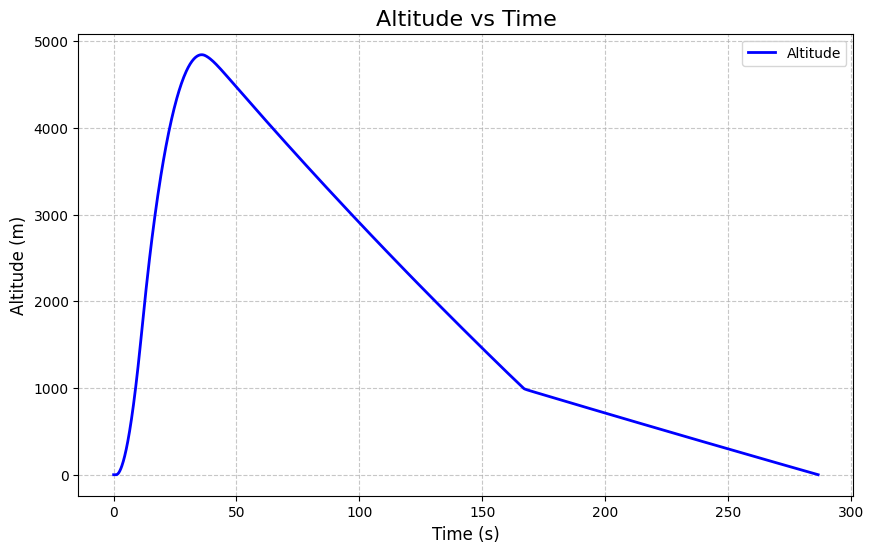

In [201]:
#Plotting custom plots
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the CSV file
# Replace 'trb_flight_data.csv' with the path to your file
csv_filename = 'trb_flight_data.csv'
df = pd.read_csv(csv_filename)

# 2. Inspect the column names (Optional: helps verify data is loaded correctly)
print("Columns found:", df.columns)

# 3. Plotting
plt.figure(figsize=(10, 6))

# NOTE: Change '# Time (s)' and ' Z (m)' below to match the exact headers in your CSV
x_column = '# Time (s)'
y_column = ' Z (m)'

plt.plot(df[x_column], df[y_column], label='Altitude', color='blue', linewidth=2)

# Labeling the graph
plt.title('Altitude vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Altitude (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 4. Save and Show the plot
plt.savefig('altitude_plot.png')
print("Plot saved as altitude_plot.png")